# Scattering-Based Images Clustering using POC

In this notebook, we illustrate how to perform image clustering using the PSSC framwork

In [1]:
import os
import sys
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import torch
from  matplotlib import pyplot as plt

sys.path.append("..")

from lib.clustering.uspec import USPEC
from lib.clustering.utils import compute_clustering_metrics
from lib.data.data_loading import ClassificationDataset
from lib.data.data_processing import convert_images_to_scat
from lib.dimensionality_reduction import pca
from lib.projections.POC import POC
from lib.scattering.scattering_methods import scattering_layer
from lib.utils.arguments import process_clustering_arguments
from lib.utils.utils import create_directory
from lib.utils.visualizations import display_cluster_imgs
from CONFIG import CONFIG

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# macros and global variables
STANDARIZE = True  # standarizing features to hvae zero-mean and unit-variance
N_DIMS = 2         # number of directions of variance to remove in POC step
DATASET = "mnist-test"  # dataset used for classification ['mnist', 'svhn']

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ROOT_PATH = os.path.dirname(os.path.dirname(os.getcwd()))
DATA_PATH = os.path.join(ROOT_PATH, CONFIG["paths"]["data_path"])

## Loading Dataset and Computing Scattering Transform

In [4]:
dataset = ClassificationDataset(data_path=CONFIG["paths"]["data_path"],
                                dataset_name=DATASET,
                                valid_size=0)
imgs, labels = dataset.get_all_data()

In [5]:
scattering_net, _ = scattering_layer()
scattering_net = scattering_net.cuda() if DEVICE.type == 'cuda' else scattering_net
scat_features  = convert_images_to_scat(imgs, scattering=scattering_net,
                                        device=DEVICE, equalize=STANDARIZE,
                                        batch_size=64)
n_labels = len(np.unique(labels))

100%|██████████| 157/157 [00:25<00:00,  6.19it/s]


## POC Projection Step

In [6]:
# reducing data dimensionalitd to d=1000 with PCA
n_feats = scat_features.shape[0]
scat_features = scat_features.reshape(n_feats, -1)
scat_features = pca(data=scat_features, target_dimensions=1000)

In [7]:
# poc projection step
poc = POC()
poc.fit(data=scat_features)
proj_data = poc.transform(data=scat_features, n_dims=N_DIMS)

In [8]:
# clustering with U-SPEC
uspec = USPEC(p_interm=4000, p_final=1000,
              n_neighbors=5, num_clusters=10, num_iters=100)

preds = uspec.cluster(data=proj_data, verbose=1)
cluster_ari, cluster_acc, cluster_nmi = compute_clustering_metrics(preds=preds, labels=labels)

Starting clustering:
  Sampling time: 28.6 seconds
  Computing affinity time: 22.93 seconds
  Transfer cut time: 9.42 seconds


In [9]:
print(f"Clustering Accuracy: {round(cluster_acc * 100, 3)}%")
print(f"Clustering NMI Score: {round(cluster_nmi * 100, 3)}%")
print(f"Clustering ARI Score: {round(cluster_ari * 100, 3)}%")

Clustering Accuracy: 95.95%
Clustering NMI Score: 90.303%
Clustering ARI Score: 91.226%


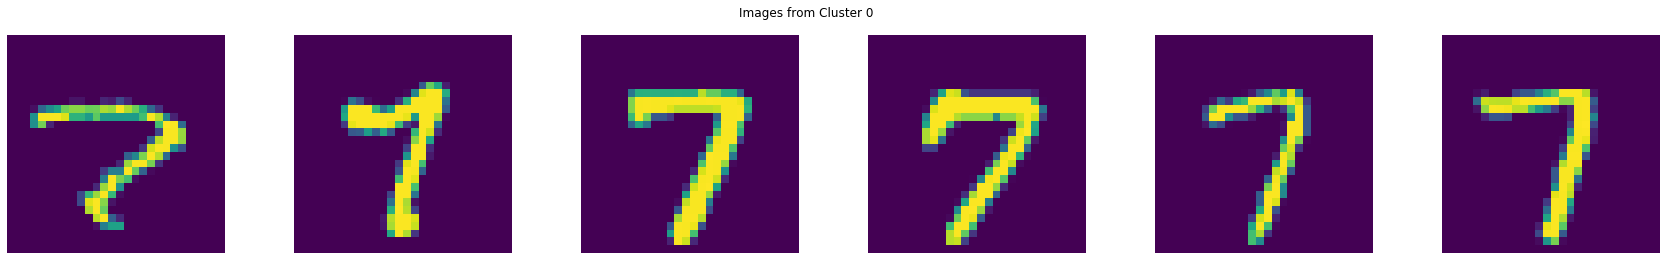

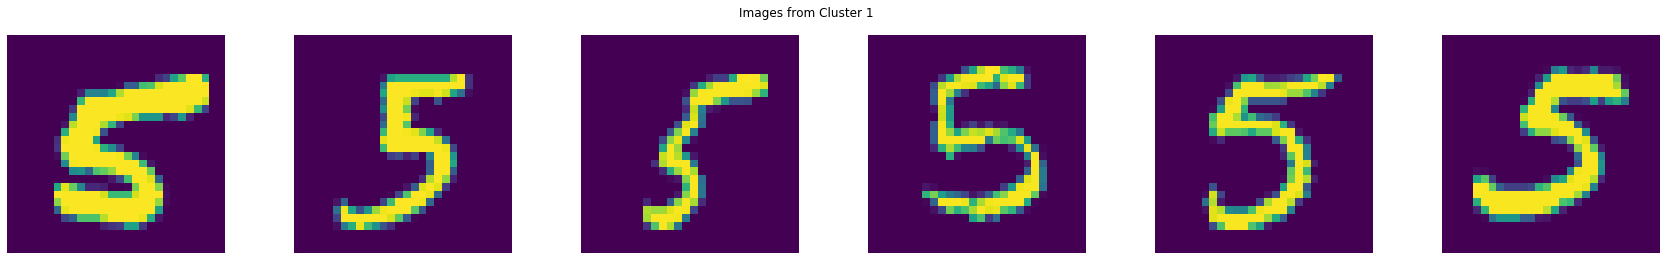

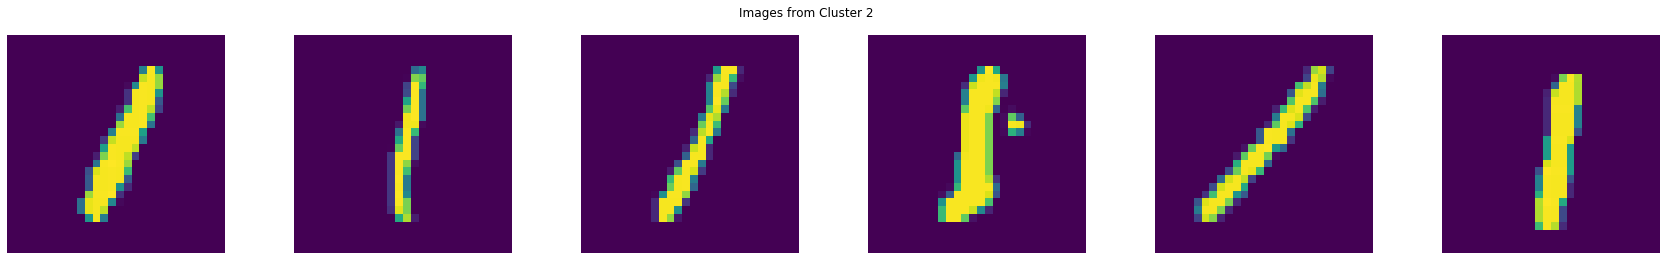

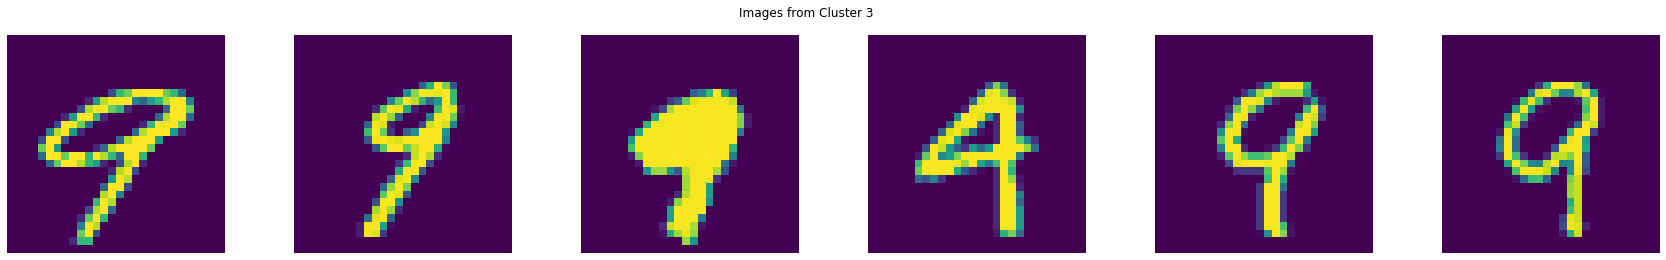

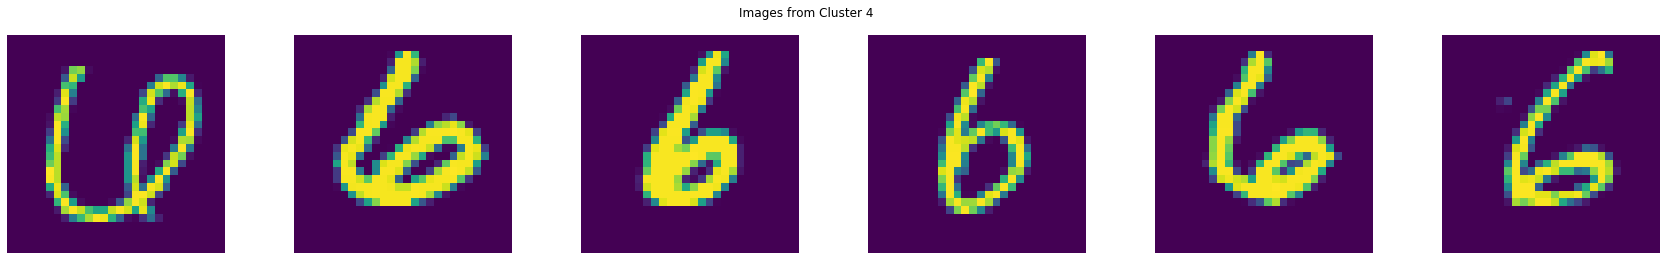

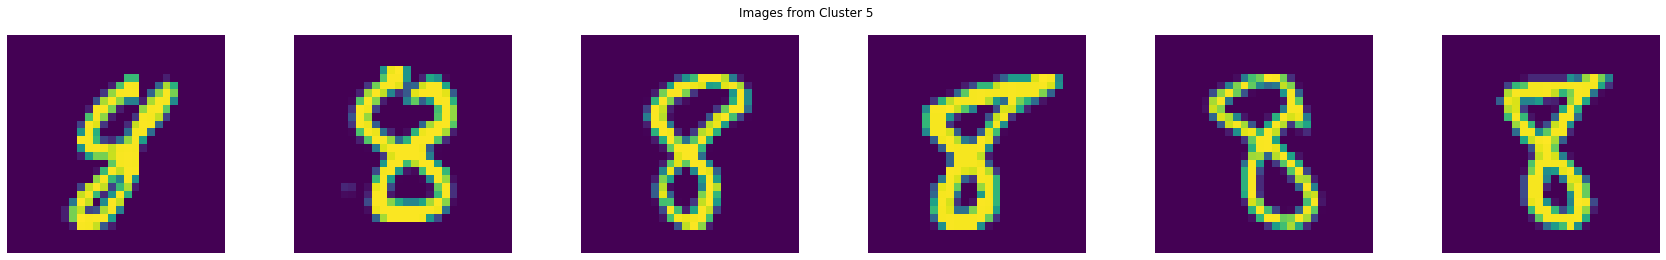

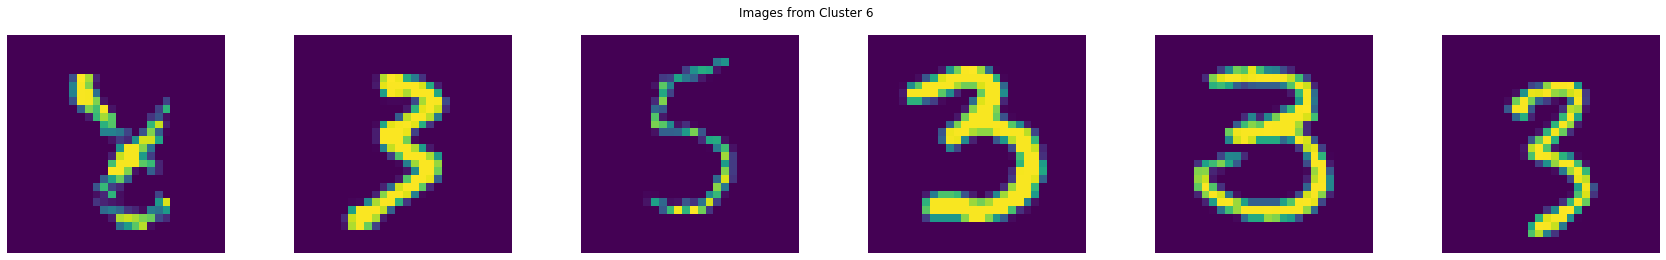

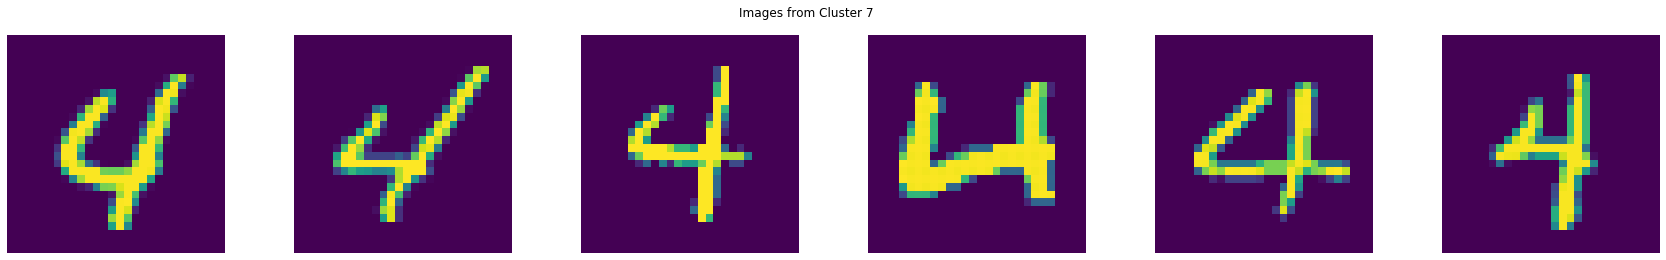

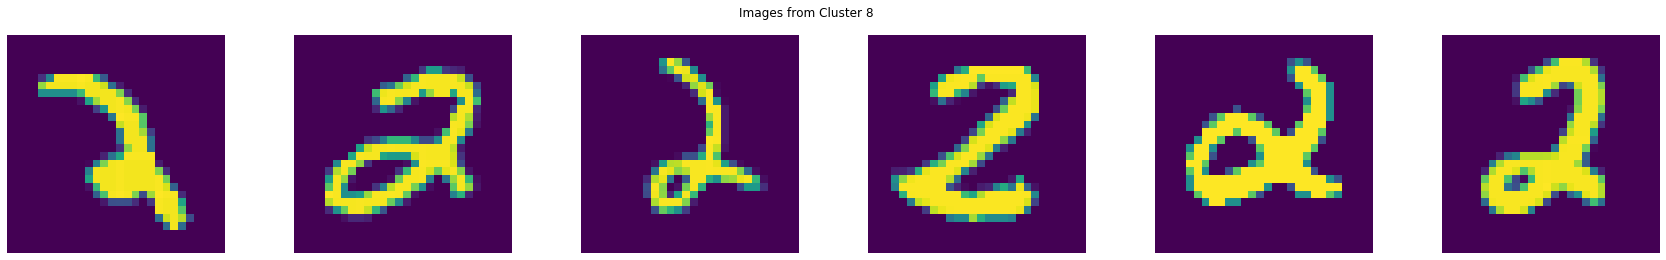

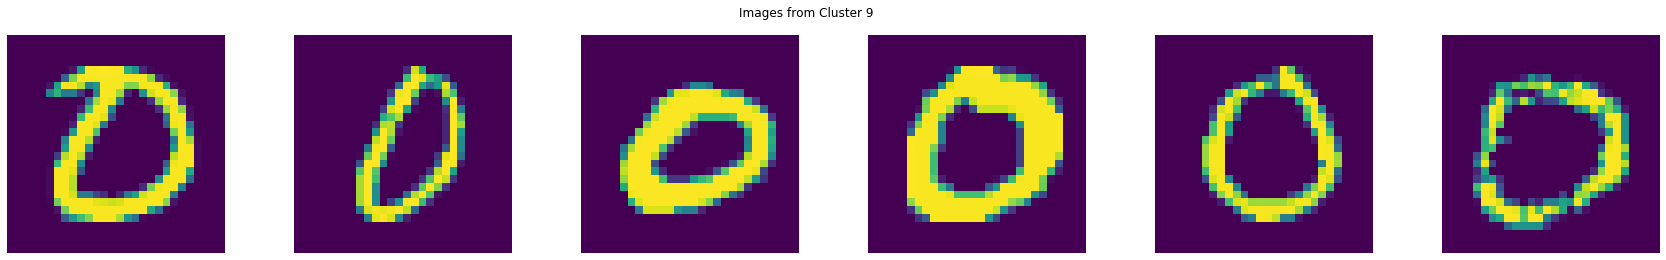

In [10]:
display_cluster_imgs(imgs, preds)